In [1]:
# # For lgpu2
# # The default HOME do not have enough space.
# import os
# print(os.path.expanduser("~"))
# os.environ["HOME"] = "/csproject/kdd/cyuab2"
# print(os.path.expanduser("~"))

In [2]:
# Clears all user-defined variables, functions, and imports without asking for confirmation.
%reset -f

In [3]:
import numpy as np
from dtaidistance import ed as dtaidistance_ed
from dtaidistance import dtw, dtw_visualisation
import pandas as pd
import matplotlib.pyplot as plt
from tslearn import metrics
from scipy.signal import sawtooth
from tqdm import tqdm
import time
from tslearn.datasets import UCR_UEA_datasets
import random

/Users/cyuab/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
# Imported Python files do not automatically reload after you modify them
# M1: Automatically Reload
%load_ext autoreload
%autoreload 2
# M2: Manual Reload
# import importlib
# import ksfdtw
# importlib.reload(ksfdtw)

# https://stackoverflow.com/questions/20309456/how-do-i-call-a-function-from-another-py-file
from ksfdtw import *

# ED, DTW

Test ED and DTW implementations in dtaidistance

In [5]:
# Generate testing time series
np.random.seed(42)
a = np.random.random(20)
b = np.random.random(20)

In [6]:
distance = dtaidistance_ed.distance(a, b)
print(f"Distance: {distance}")

Distance: 2.3275702573015664


In [7]:
dist = 0
l = min(len(a), len(b)) # The original ed.distance can handle different lengths.
for i in range(0, l):
    dist += (a[i]-b[i])**2
print("Distance: ",np.sqrt(dist))

Distance:  2.3275702573015664


In [8]:
distance = dtw.distance(a, b)
print(f"Distance: {distance}")
distance = dtw.distance_fast(a, b)
print(f"Distance: {distance}")

Distance: 0.7494163979271871
Distance: 0.7494163979271871


In [9]:
%%time
distance = dtw.distance(a, b, window=4)
print(f"Distance: {distance}")

Distance: 0.9681751552406113
CPU times: user 274 μs, sys: 37 μs, total: 311 μs
Wall time: 285 μs


In [10]:
path = dtw.warping_path(a, b, window=4)
# path

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

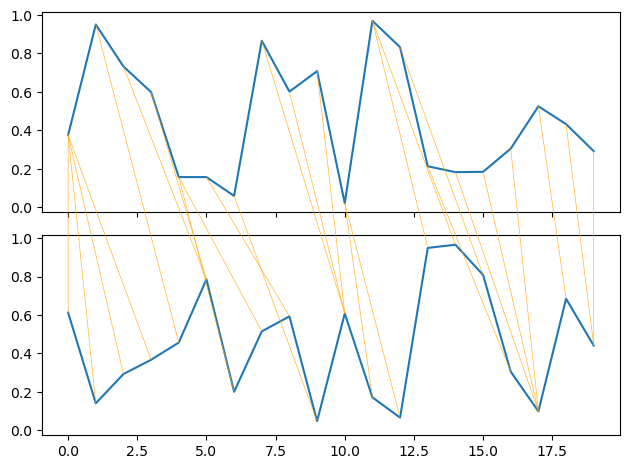

In [11]:
dtw_visualisation.plot_warping(a, b, path)

In [12]:
# Test whether the local function is ED
dist = 0
for i in range(0, len(path)):
    dist += (a[path[i][0]] - b[path[i][1]])**2
print("Distance: ",np.sqrt(dist))

Distance:  0.9681751552406113


In [13]:
# Use the self wrapped version
print(dtai_ed(a,b), dtai_dtw(a,b,_,4))

2.3275702573015664 0.9681751552406113


In [14]:
# Data from https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q = pd.Series(np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]))
c = pd.Series(np.array([-0.12, -0.16, -0.13,  0.28,  0.37,  0.39,  0.18,  0.09,  0.15, -0.06,  0.06, -0.07, -0.13, -0.18, -0.26]))
len(q), len(c)

(15, 15)

In [15]:
dtai_ed(q, c)

19.942780648645762

# Interpolation

In [16]:
a = np.array([1,2,3,4,5,6])
nearest_neighbor_interpolation(a, 8)

array([1, 2, 3, 3, 4, 5, 6, 6])

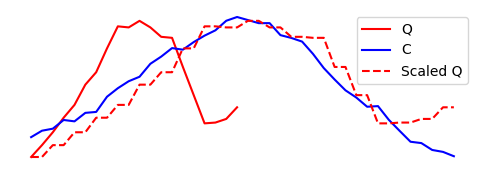

In [17]:
np.random.seed(0)
q = np.cumsum(np.random.rand(20) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 20)))
c = np.cumsum(np.random.rand(40) * 2 - 1 + np.sin(np.linspace(0, 2 * np.pi, 40)))
# c_x2 = np.linspace(0, 1, 10)
# c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
# c_y2 = c_y2 *5
# offset = c[-1] - c_y2[0]
# c_y2 = c_y2 + offset
# c = np.concatenate([c, c_y2])
q_scaled = nearest_neighbor_interpolation(q, len(c))

q = normalize(q)
c = normalize(c)
q_scaled = normalize(q_scaled)

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(6, 2))

ax1.plot(q, label='Q', color='red')
ax1.plot(c, label='C', color='blue')
ax1.plot(q_scaled, label='Scaled Q', linestyle='--', color='red')

# ax1.set_title('Example of US')
ax1.legend()

# https://stackoverflow.com/questions/9295026/how-to-remove-axis-legends-and-white-padding
plt.axis('off')
# https://www.tutorialspoint.com/save-the-plots-into-a-pdf-in-matplotlib
plt.savefig("../figures/us.pdf", format="pdf", bbox_inches="tight")
plt.show()


Another example

In [18]:
c_x1 = np.linspace(0, 4 * np.pi, 100)
c_y1 = np.sin(c_x1) * 50 + 50  # Scale to range around 0~100
c_x2 = np.linspace(0, 1, 20)
c_y2 = np.piecewise(c_x2, [c_x2 < 0.5, c_x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
c_y2 = c_y2 * 50  # Scale it similarly
offset = c_y1[-1] - c_y2[0]
c_y2 = c_y2 + offset
c = np.concatenate([c_y1, c_y2])
q_x = np.linspace(0, 4 * np.pi, 70)
q = np.sin(q_x) * 50 + 50  # Scale to range around 0~100
m = len(q)
n = len(c)
print(m, n)


70 120


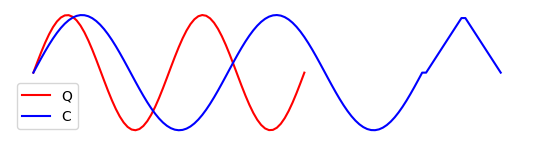

In [19]:
fig, ax1 = plt.subplots(figsize=(6, 2))
plt.plot(q, color='red', label='Q')
plt.plot(c, color='blue', label='C')
# plt.title('C vs. Q')
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.savefig("../figures/us-prefix.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [20]:
c_prefix = c[:100]
c_prefix_scaled = nearest_neighbor_interpolation(c_prefix, len(q))

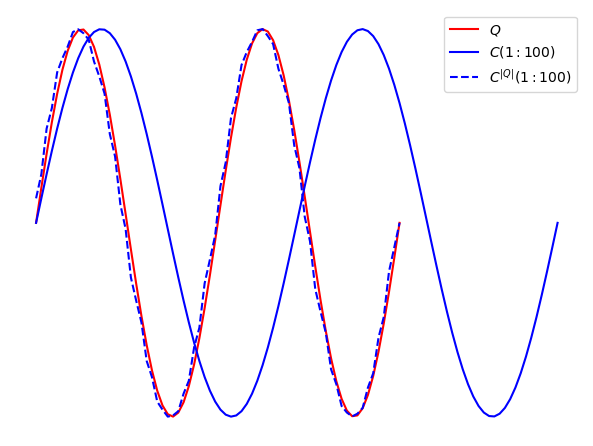

In [21]:
plt.plot(q, color='red', label='$Q$')
# plt.plot(c, color='blue', label='$C$')
plt.plot(c_prefix, color='blue', label='$C(1:100)$')
plt.plot(c_prefix_scaled, linestyle='--', color='blue', label='$C^{|Q|}(1:100)$')
# plt.title('c_prefix vs. c_prefix_interpolated')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.show()


Simply performing dtw on Q and C returns a bad result.

As shown in the above graph, Q and scaled C(1:100) have a good match.

In [22]:
dtai_ed(q, c_prefix_scaled)

27.04740913981143

In [23]:
l = 2 # scaling_factor 
best_so_far, best_k = us_usdtw(q, c, l, "ed")

In [24]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(20.03655846980296, 101, 144.28571428571428)

# Lower Bounds for Distance Measures

In [25]:
# Sample sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

In [26]:
def lb_shen_argmin_q_of_cj(q, c, l=1, r=0.1):
    if isinstance(r, float):
        # print("r is a float.")
        minlen = min(len(a), len(b))
        r = int(minlen * r)
    elif isinstance(r, int):
        # Do something when r is an int
        # print("r is an integer.")
        # window=r
        pass
    else:
        raise ValueError("r must be either an integer or a float.")
    # print("Hello 4")
    # if isinstance(r, float):
    #     # Do something when r is a float
    #     print("r is a float.")
    #     # Add your float-specific logic here
    # elif isinstance(r, int):
    #     # Do something when r is an int
    #     print("r is an integer.")
    #     # Add your integer-specific logic here
    # else:
    #     raise ValueError("r must be either an integer or a float.")
    m = len(q)
    n = len(c)
    dist = lambda a, b: (a - b)**2

    window_contrib = []
    dist_total = 0
    # window_contrib.append((0, 0))
    dist_total += dist(q[0], c[0]) 
    window_contrib.append(q[0]) # Window for c_o
    
    for j in range(1, min(np.ceil(l*m), n - 1)):
        start = int(max(0, np.ceil(j/l) - r))
        end = int(min(np.ceil(j*l) + r, m-1))
        # print(j, start, end)
        q_window = q[start:end+1]
        # print("q_window ", q_window)
        argmin = np.argmin([dist(c[j], q_k) for q_k in q_window]) #q_k = q_argmin
        min_dist = 0
        min_dist = dist(c[j], q_window[argmin])
        # print(min_dist)
        # min_dist = np.min([dist(c[j], q_k) for q_k in q_window])
        # window_contrib.append((j, q_window[argmin]))
        window_contrib.append(q_window[argmin])
        dist_total += min_dist
    dist_total += dist(q[-1], c[-1])
    window_contrib.append(q[-1]) 
    return np.sqrt(dist_total), window_contrib

In [27]:
def lb_shen(q, c, l=1, r=0.1):
    if isinstance(r, float):
        # print("r is a float.")
        minlen = min(len(a), len(b))
        r = int(minlen * r)
    elif isinstance(r, int):
        # Do something when r is an int
        # print("r is an integer.")
        # window=r
        pass
    else:
        raise ValueError("r must be either an integer or a float.")
    m = len(q)
    n = len(c)
    dist = lambda a, b: (a - b)**2

    dist_total = 0
    # window_contrib.append((0, 0))
    dist_total += dist(q[0], c[0]) 
    
    for j in range(1, min(np.ceil(l*m), n - 1)):
        start = int(max(0, np.ceil(j/l) - r))
        end = int(min(np.ceil(j*l) + r, m-1))
        # print(j, start, end)
        q_window = q[start:end+1]
        # print("q_window ", q_window)
        min_dist = np.min([dist(c[j], q_k) for q_k in q_window])
        # print(min_dist)
        # min_dist = np.min([dist(c[j], q_k) for q_k in q_window])
        # window_contrib.append((j, q_window[argmin]))
        dist_total += min_dist
    dist_total += dist(q[-1], c[-1])
    return np.sqrt(dist_total)

In [46]:
def lb_dummy(q, c, l=1, r=0.1):
    return 0

In [28]:
def lb_kim(q, c, l=1, r=0.1):
    return np.sqrt(max((q[0]-c[0])**2,(q[-1]-c[-1])**2,(max(q)-max(c))**2,(min(q)-min(c))**2))

In [29]:
def lb_kim_fl(q, c, l=1, r=0.1):
    return np.sqrt((q[0]-c[0])**2+(q[-1]-c[-1])**2)

In [30]:
dist, _ = lb_shen_argmin_q_of_cj(q, c, r=5)
dist

np.float64(2.2637676038911785)

In [31]:
dtai_dtw(q, c, r =5)

3.7060581448719647

In [32]:
# LB_Keogh
env_low, env_up = metrics.lb_envelope(q, radius=5)
metrics.lb_keogh(ts_query=c, envelope_candidate=(env_low, env_up))


np.float64(2.240514607517655)

In [33]:
metrics.lb_keogh(ts_query=c, ts_candidate=q, radius=5)

np.float64(2.240514607517655)

$LB_{Shen}$ lower bounds DTW.

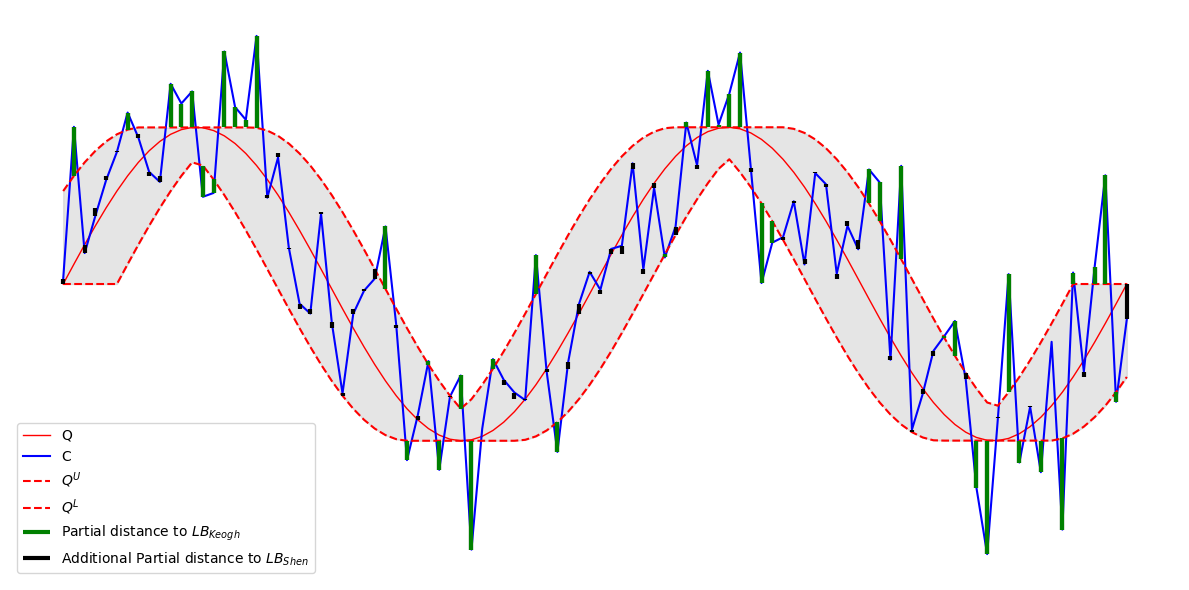

In [34]:
def plot_lb_keogh_full(q, c, radius):
    x = np.arange(len(q))
    lower, upper = lb_keogh_envelope(q, radius)
    lb = lb_keogh(q, c, radius)

    plt.figure(figsize=(12, 6))

    # Plot Q and C
    plt.plot(x, q, label='Q', color='red', linewidth=1)
    plt.plot(x, c, label='C', color='blue', linewidth=1.5)
    # Plot envelope
    plt.plot(x, upper, label='$Q^U$', linestyle='--', color='red', linewidth=1.5)
    plt.plot(x, lower, label='$Q^L$', linestyle='--', color='red', linewidth=1.5)
    plt.fill_between(x, lower, upper, color='gray', alpha=0.2)
    # Vertical bars
    # Old version
    # for i in x:
    #     if c[i] > upper[i]:
    #         plt.vlines(i, upper[i], c[i], color='black', linewidth=1.5)
    #     elif c[i] < lower[i]:
    #         plt.vlines(i, lower[i], c[i], color='black', linewidth=1.5)

#     print(len(lower))
    lb_shen_dist, first_pair_smallest_elts_last_pair = lb_shen_argmin_q_of_cj(q, c, r=5)
#     print(lb_shen_dist)
#     print(len(np.array(first_pair_smallest_elts_last_pair)))
    plt.vlines(np.arange(len(q)), c, first_pair_smallest_elts_last_pair,
           label='Additional Partial distance to $LB_{Shen}$', color='black', linewidth=3.0)
    # Elegant version
    plt.vlines(np.arange(len(q)), c, np.clip(c, lower, upper),
           label='Partial distance to $LB_{Keogh}$', color='green', linewidth=3.0)

    # plt.title(f"LB_Keogh Visualization\nLower Bound = {lb:.4f}")
    # plt.xlabel("Time Index")
    # plt.ylabel("Value")

    # Get all legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Swap the last two (assuming they are in the expected order)
    handles[-2], handles[-1] = handles[-1], handles[-2]
    labels[-2], labels[-1] = labels[-1], labels[-2]

    plt.legend(handles=handles, labels=labels, loc='lower left')
    # plt.legend(loc='upper right')
    # plt.grid(True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("../figures/lb_keogh-lb_shen.pdf", format="pdf", bbox_inches="tight")
    plt.show()

plot_lb_keogh_full(q, c, radius=5)



# ---

---

In [35]:

# import math


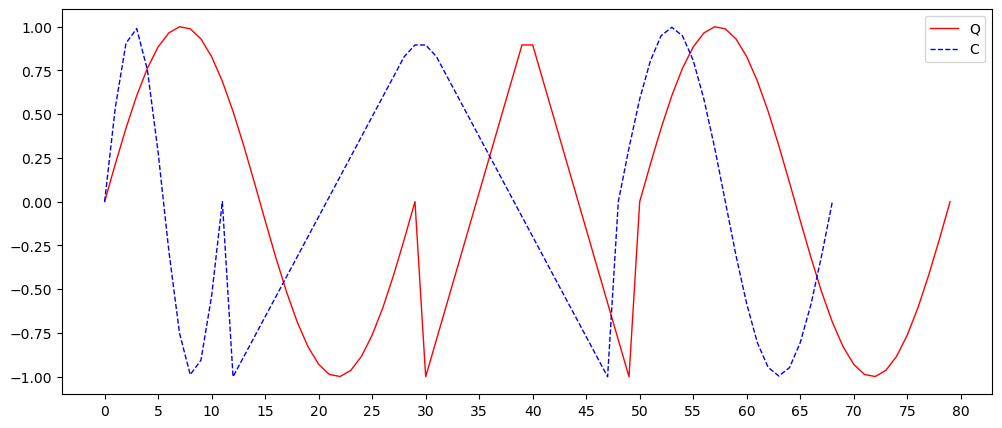

(80, 69)

In [36]:
# Step 1: Create segments
def generate_segments():
    s1 = np.sin(np.linspace(0, 2 * np.pi, 30)) 
    # s1 = np.linspace(0, 1, 15)
    s2 = sawtooth(np.linspace(0, 2 * np.pi, 20), 0.5)  # Triangle wave (periodic)
    # s2 = np.concatenate([np.ones(10), np.linspace(1, 0.5, 5)])
    s3 = np.tile([-1, 1], 30)
    tail = np.linspace(1, 0, 30)
    return s1, s2, s3, tail
    # return s1, s2, tail

# Step 3: Compose sequences
def create_series(with_tail=False):
    s1, s2, s3, tail = generate_segments()
    # s1, s2, tail = generate_segments()
    Q = np.concatenate([s1, s2, s1])
    # Q = np.concatenate([s1, s2])
    C = np.concatenate([
        linear_interpolation(s1, int(len(s1)*0.4)),
        linear_interpolation(s2, int(len(s2)*1.8)),
        linear_interpolation(s1, int(len(s1)*0.7))
    ])
    if with_tail:
        C = np.concatenate([C, tail])
    return Q, C

Q, C = create_series(False)

# Step 4: Plotting with ground truth segment boundaries
def plot_segmented_series(Q, C):
    plt.figure(figsize=(12, 5))
    plt.plot(Q, label="Q", color='red', linewidth=1)
    plt.plot(C, label="C", color='blue', linestyle='--', linewidth=1)

    # for idx in q_segments[1:-1]:  # skip 0 and end
    #     plt.axvline(idx, color='blue', linestyle='--', alpha=0.5)
    # for idx in c_segments[1:-1]:
    #     plt.axvline(idx, color='red', linestyle=':', alpha=0.5)

    # plt.title("Segmented Time Series with Expression Rate Difference + Tail")
    from matplotlib.ticker import MultipleLocator
    plt.gca().xaxis.set_major_locator(MultipleLocator(5))
    plt.legend()
    # plt.grid(True)
    # plt.xlabel("Time index")
    # plt.ylabel("Value")
    plt.show()

# # Step 5: Ground truth (simulated for this synthetic case)
# q_segments = [0, 30, 60, 90]  # Original segments in Q
# c_segments = [0,
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)),
#               len(scale_segment(np.linspace(0, 1, 30), 0.7)) +
#               len(scale_segment(np.ones(30), 1.3)),
#               len(C)]  # including tail

plot_segmented_series(Q, C)
len(Q), len(C)


In [68]:
def ps_distance_p(Q, C, l, r, P, distance_method='ed', lower_bound=lb_kim_fl):
    # print("Hello World2")
    no_of_iteration = 0
    INF = float('inf')

    m, n = len(Q), len(C)
    Qp_elen, Cp_elen = np.floor(m/P), np.floor(n/P) # Expected length of each subsequence piece Q_p and C_p
    # D = np.full((m+1, n+1, P+1), np.inf)
    # Minimum cost to align the **first i** elements of Q and the **first j** elements of C using s segments
    D = np.full((m+1, n+1, P+1), INF) 
    # The indics of D are from 0 to m-1, n-1, and P-1.
    # D[2,:,:] refers to the first 3 elements of Q. The are inclusive.

    # backtrack = np.full((m+1, n+1, P+1, 2), -1, dtype=int)  # The last dimension is used to store a pair of cutting points
     # Parent table to trace back: stores (prev_i, prev_j)
    parent = [[[(None, None) for _ in range(P + 1)] for _ in range(n + 1)] for _ in range(m + 1)] #backtracking

    # Distance cache: (qi_start, i, cj_start, j) → distance
    lb_cache = {}
    dist_cache = {}

    D[0][0][0] = 0 # Base case

    total_iters = P * m * n
    progress = tqdm(total=total_iters, desc="DP Progress") # For progress tracking
    start_time = time.time() # Timing

    for p in range(1, P+1):
        for i in range(1, m+1):
            for j in range(1, n+1):
                
                # # lower bound pruning
                # key = (0, i, 0, j)
                # if key not in lb_cache:
                #     lb_cost, _ = lb_shen_argmin_q_of_cj(Q[0:i], C[0:j], l, r)
                #     lb_cache[key] = lb_cost
                # D[i][j][p] = lb_cost

                progress.update(1)
                # print("p i j", p, i, j)
                for Qp_len in range(max(1, int(np.ceil(Qp_elen/l))), min(int(np.ceil(Qp_elen*l)), i)+1):
                    qi_start = i-Qp_len
                    # Q[qi_start:i]
                    # Its corresponding shortest C
                    # C[j-max(1, int(np.ceil(C_p_elen/l))):j]
                    # Its corresponding longest C
                    # C[j-min(int(np.ceil(C_p_elen*l)), j) :j]
                    for Cp_len in range(int(np.ceil(Qp_len/l)), min(int(np.ceil(Qp_len*l)), j)+1):
                    # for C_p in range(max(1, int(np.ceil(C_p_elen/l))), min(int(np.ceil(C_p_elen*l)), j)+1):
                        # if (Q_p/C_p >l) or (C_p/Q_p >l): # scaling constraint
                        #     continue
                        # print("Q_p C_p Q_p/C_p", Q_p, C_p, Q_p/C_p)
                        cj_start = j-Cp_len
                        # Q[cj_start:i]
                        prev_cost = D[qi_start][cj_start][p-1]
                        if prev_cost == INF: # Stop expensive computation
                            continue
                        if prev_cost > D[i][j][p]: # what we currently have is the upper bound of the real value
                            continue
                        key = (qi_start, i, cj_start, j)
                        # lower bound pruning
                        if key not in lb_cache:
                            lb_cache[key] = lower_bound(Q[qi_start:i], C[cj_start:j], l, r)
                            # lb_cache[key], _ = lb_shen(Q[qi_start:i], C[cj_start:j], l, r)
                        if lb_cache[key] + prev_cost >= D[i][j][p]:
                            # print("Lower bound")
                            continue  # Skip: can't improve

                        if key not in dist_cache:
                            dist_cache[key] = us_usdtw_p(Q[qi_start:i], C[cj_start:j], l, r, distance_method)
                            no_of_iteration = no_of_iteration + 1
                            # dist_cache[key] = dtaidistance_ed.distance(Q[qi_start:i], C[cj_start:j])
                        cost = dist_cache[key]
                        
                        new_cost = prev_cost + cost
                        if new_cost < D[i][j][p]:
                            D[i][j][p] = new_cost
                            parent[i][j][p] = (qi_start, cj_start)
                        # D[i][j][p] = min(D[i][j][p], D[qi_start][cj_start][p-1]+cost)
    
    progress.close()
    elapsed = time.time() - start_time
    print(f"Total iterations: {no_of_iteration}")
    print(f"\nTotal time: {elapsed:.2f} seconds")
    # Backtracking to recover the cutting points
    cuts = []
    i, j, p = m, n, P
    while p > 0:
        qi_start, cj_start = parent[i][j][p]
        cuts.append(((qi_start, i), (cj_start, j)))  # Q segment, C segment
        i, j, p = qi_start, cj_start, p - 1
    cuts.reverse()

    return D[m][n][P], cuts

    # # Base case
    # p = 1 
    # for i_e in range(2, m+1): # e: ending, we need (m+1) to enumerate until m (inclusive)
    #     for j_e in range(2, n+1): # same as above
    #         m_p, n_p = i_e-0, j_e-0 # lengths of the two subsequence under comparison
    #         if (m_p > l*(n_p)) or (n_p > l*(m_p)): # scaling constraint
    #             continue
    #         if m_p < np.floor(s_Q/l) or n_p < np.floor(s_C/l): # min length of each subsequence constraint
    #             continue
    #         if m_p > np.floor(s_Q*l) or n_p > np.floor(s_C*l): # max length of each subsequence constraint
    #             continue
    #         dist = us_usdtw_p(Q[0:i_e], C[0:j_e], l, "dtw") # Sequences from 0 to i_e (j_e) (exclusive)
    #         #
    #         # dist, _ = lb_shen_argmin_q(Q[0:i_e], C[0:j_e], l)


    #         D[i_e-1, j_e-1, p-1] = dist # i_e-1 and j_e-1 as the indics for ending of Q, C in D are inclusive. 
    #         # p -1 as it counts from 0.
    #         backtrack[i_e-1, j_e-1, p-1] = [0, 0]
    #         no_of_iteration = no_of_iteration + 1
    # # Recursive case
    # for p in range(2, P+1):
    #     # Assigned length of previous subsequence constraint
    #     Q_occupied = 0
    #     C_occupied = 0
    #     Q_occupied = int(np.floor((s_Q/l)*(p-1)))
    #     C_occupied = int(np.floor((s_C/l)*(p-1)))
    #     for i_e in range(Q_occupied+2, m+1): # (Q_occupied+1) is the first available time stamps
    #         for j_e in range(C_occupied+2, n+1): # same as above
    #             best_so_far = np.inf
    #             best_indices = (-1, -1)
    #             # Iterate over all previous indices
    #             for i_s in range(Q_occupied, i_e+1):
    #                 for j_s in range(C_occupied, j_e+1):
    #                     m_p, n_p = i_e-i_s, j_e-j_s
    #                     if m_p < 2 or n_p < 2: # Their lengths should be at least 2. This constraint is also included in subsequence constraint
    #                         continue
    #                     if (m_p > l*(n_p)) or (n_p > l*(m_p)): # scaling constraint
    #                         continue    
    #                     if m_p < np.floor(s_Q/l) or n_p < np.floor(s_C/l): # min length of each subsequence constraint
    #                         continue
    #                     if m_p > np.floor(s_Q*l) or n_p > np.floor(s_C*l): # max length of each subsequence constraint
    #                         continue
    #                     dist = D[i_s-1, j_s-1, (p-1)-1] + us_usdtw_p(Q[i_s:i_e], C[j_s:j_e], l, "dtw")
    #                     # dist_cur, _ = lb_shen_argmin_q(Q[i_s:i_e], C[j_s:j_e], l)
    #                     # dist = D[i_s-1, j_s-1, (p-1)-1] + dist_cur

    #                     if dist < best_so_far:
    #                         best_so_far = dist
    #                         best_indices = (i_s, j_s)
    #                     no_of_iteration = no_of_iteration + 1
    #             D[i_e-1, j_e-1, p-1] = best_so_far
    #             backtrack[i_e-1, j_e-1, p-1] = best_indices
    # return D, backtrack

In [69]:
%%time
D, cuts = ps_distance_p(Q, C, 2, 0.1, 3, "dtw", lb_kim_fl) 
# Running time
# LB_Dummy Total iterations: 616434 Total time: 86.75 seconds
# LB_Kim-FL Total iterations: 478932 Total time: 70.78 seconds
# LB_Kim Total iterations: 492731 Total time: 79.74 seconds


# No lower bound: Total iterations: 842737 Total time: 110.87 seconds
# LB_kim: Total iterations: 526545 Total time: 76.29 seconds
# LB_Yi: Total iterations: 376739 Wall time: 3min 18s
# LB_Yi pruned: 

DP Progress: 100%|██████████| 16560/16560 [01:24<00:00, 195.01it/s]

Total iterations: 539490

Total time: 84.92 seconds
CPU times: user 1min 21s, sys: 953 ms, total: 1min 22s
Wall time: 1min 24s


In [73]:
D # 1.649901045302047 2.1510656391256022

np.float64(2.1510656391256022)

In [77]:
cuts

[((0, 35), (0, 20)), ((35, 52), (20, 50)), ((52, 80), (50, 69))]

We are going to introduce some common time series libraries.
- [tslean](https://tslearn.readthedocs.io/en/stable/)
- [sktime](https://www.sktime.net/en/stable/)
- [pyts](https://pyts.readthedocs.io/en/stable/)
- [aeon](https://www.aeon-toolkit.org/en/stable/)
- [dtaidistance](https://dtaidistance.readthedocs.io/en/latest/)

And some time series database.
- [Time Series Classification Website](https://www.timeseriesclassification.com/index.php)

# Experiments

About the dataset
- Class 1 is "gun" and class 2 is "no gun (pointing)"
- References
    - https://www.timeseriesclassification.com/description.php?Dataset=GunPoint
    - https://www.timeseriesclassification.com/description.php?Dataset=GunPointOldVersusYoung
    - https://rdrr.io/cran/LPStimeSeries/man/GunPoint.html
    - Related papers
        - https://www.cs.ucr.edu/~eamonn/DTW_myths.pdf
        - https://arxiv.org/pdf/1810.07758

Best match index: 0, Label: 1
Distance: 0.0000


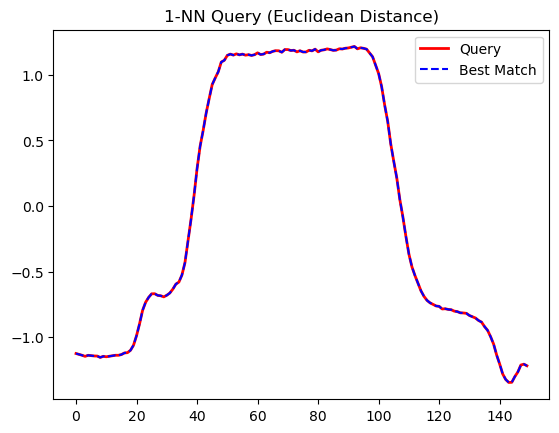

In [ ]:
# Import dataset


# Load dataset
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("GunPoint")
X_train = X_train.squeeze()

# Squeeze to 2D (n_samples, time_length)(univariate)
X_train = X_train.squeeze()
X_test = X_test.squeeze()

query_ts = X_test[0]

# Compute Euclidean distances to all training samples
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

distances = np.array([euclidean_distance(query_ts, x) for x in X_test])

# Find best match
best_idx = np.argmin(distances)
best_match = X_test[best_idx]

print(f"Best match index: {best_idx}, Label: {y_test[best_idx]}")
print(f"Distance: {distances[best_idx]:.4f}")

# Plot
plt.plot(query_ts, label="Query", linewidth=2, color="red")
plt.plot(best_match, label="Best Match", linestyle="--", color="blue")
plt.legend()
plt.title("1-NN Query (Euclidean Distance)")
plt.show()



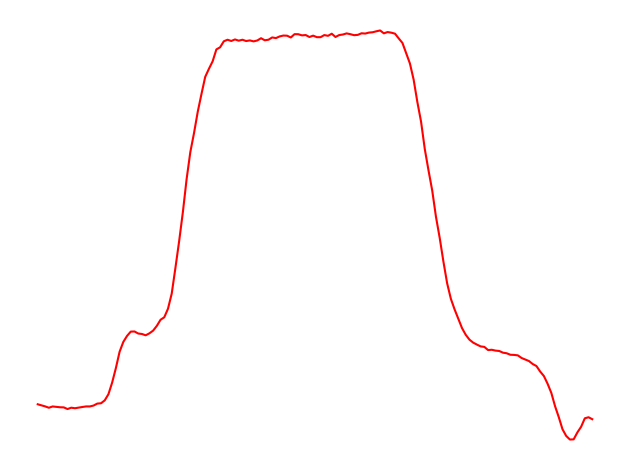

In [ ]:
# gun
plt.plot(X_test[y_test == 1][0], color="red")
plt.axis('off')
plt.tight_layout()
plt.show()

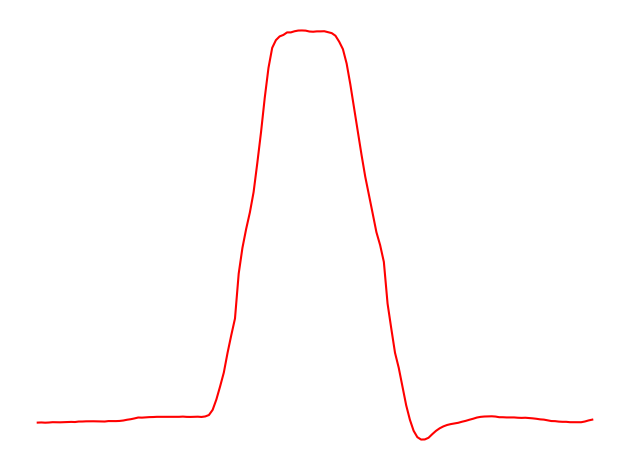

In [ ]:
# pointing
plt.plot(X_test[y_test == 2][0], color="red")
plt.axis('off')
plt.tight_layout()
plt.show()

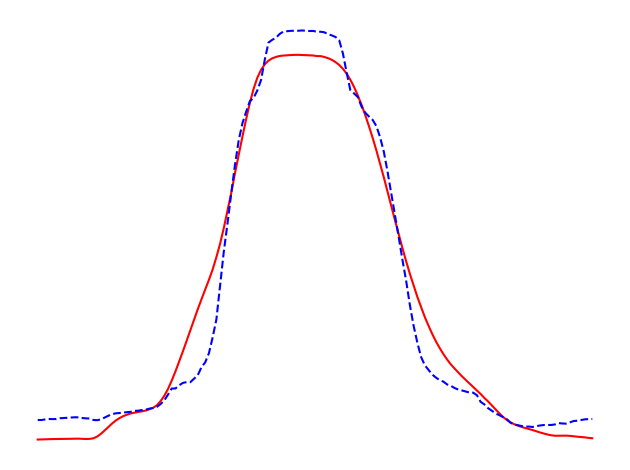

In [ ]:
# gun
# import numpy as np
# import matplotlib.pyplot as plt

# Compute the mean time series
prototype_mean = np.mean(X_test[y_test == 1], axis=0)
# Compute the median time series
median_prototype = np.median(X_test[y_test == 1], axis=0)

# Plot the mean prototype
plt.plot(prototype_mean, label="Mean Prototype", color="red")
# Plot the median prototype
plt.plot(median_prototype, label="Median Prototype", color="blue", linestyle="--")
# plt.title("Idealized Prototype")
plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

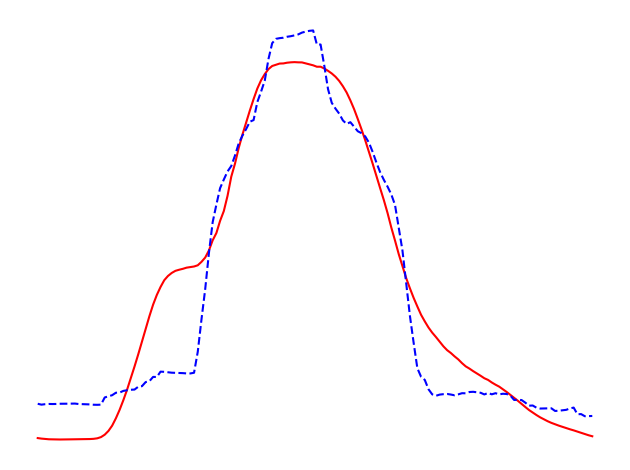

In [ ]:
# pointing
# Compute the mean time series
prototype_mean = np.mean(X_test[y_test == 2], axis=0)
# Compute the median time series
median_prototype = np.median(X_test[y_test == 2], axis=0)

# Plot the mean prototype
plt.plot(prototype_mean, label="Mean Prototype", color="red")
# Plot the median prototype
plt.plot(median_prototype, label="Median Prototype", color="blue", linestyle="--")
# plt.title("Idealized Prototype")
plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
Q = X_test[y_test == 1][0]

In [ ]:
P = 3
m = len(Q)
m_p = np.floor(m/3).astype(int)

P,m,m_p


(3, 150, np.int64(50))

In [ ]:
# # Create P subsequences
# subsequences = [Q[i*m_p:(i+1)*m_p] for i in range(P)]

# # Print the subsequences to verify
# for idx, subseq in enumerate(subsequences):
#     print(f"Subsequence {idx+1}: {subseq}")
# len(subsequences)

In [ ]:
# Example time series data (Q) and number of subsequences (P)
Q = X_test[y_test == 1][0]
P = 3

m = len(Q)
subseq_length = np.floor(m / P).astype(int)  # Length of each subsequence
remainder = m % P  # Remainder to distribute, how many subsequences should have one extra value

# Create P subsequences
subsequences = []
start_idx = 0

for i in range(P):
    # Determine the end index for the current subsequence
    end_idx = start_idx + subseq_length + (1 if i < remainder else 0) # For each subsequence, we add one extra element if the subsequence index is less than the remainder.
    subsequences.append(Q[start_idx:end_idx])
    start_idx = end_idx  # Update start index for next subsequence

# Print the subsequences to verify
for idx, subseq in enumerate(subsequences):
    print(f"Subsequence {idx+1}: {subseq}")
    print(len(subseq))

Subsequence 1: [-1.1250133  -1.1313383  -1.1382884  -1.1466873  -1.1386387  -1.1414312
 -1.1436908  -1.1443789  -1.1549123  -1.1464212  -1.1497246  -1.1457227
 -1.1419403  -1.1384288  -1.1385201  -1.1329855  -1.1206946  -1.1185964
 -1.1005789  -1.0618869  -0.98877018 -0.89804927 -0.79586606 -0.73432104
 -0.69687043 -0.66992052 -0.66910759 -0.68194036 -0.68481332 -0.69305372
 -0.68082429 -0.66386028 -0.63402064 -0.5958185  -0.58019191 -0.52662465
 -0.43224316 -0.27027162 -0.10318644  0.07854224  0.28436347  0.45409849
  0.57409933  0.70714616  0.8182297   0.92508286  0.97561574  1.0226481
  1.0969569   1.1102969 ]
50
Subsequence 2: [1.1479976 1.1575769 1.1498129 1.1594703 1.1517029 1.157521  1.1494632
 1.153298  1.1473326 1.1530236 1.1671015 1.1542641 1.1576391 1.1720068
 1.1678774 1.1783764 1.1837646 1.1829012 1.1717443 1.192459  1.1921674
 1.184896  1.1869894 1.1746437 1.183216  1.1736466 1.1736466 1.1868374
 1.1821363 1.1953776 1.174863  1.1868828 1.1903198 1.1972967 1.1923345
 1.186

In [ ]:

l = 2
random.seed(20) 
for idx, subseq in enumerate(subsequences):
    new_length = random.randint(np.ceil(m_p/l).astype(int), np.ceil(m_p*l).astype(int))
    subsequences[idx] =nearest_neighbor_interpolation(subsequences[idx],new_length)
    print(f"Subsequence {idx+1}: {subseq}")
    print(len(subsequences[idx]))

    

Subsequence 1: [-1.1250133  -1.1313383  -1.1382884  -1.1466873  -1.1386387  -1.1414312
 -1.1436908  -1.1443789  -1.1549123  -1.1464212  -1.1497246  -1.1457227
 -1.1419403  -1.1384288  -1.1385201  -1.1329855  -1.1206946  -1.1185964
 -1.1005789  -1.0618869  -0.98877018 -0.89804927 -0.79586606 -0.73432104
 -0.69687043 -0.66992052 -0.66910759 -0.68194036 -0.68481332 -0.69305372
 -0.68082429 -0.66386028 -0.63402064 -0.5958185  -0.58019191 -0.52662465
 -0.43224316 -0.27027162 -0.10318644  0.07854224  0.28436347  0.45409849
  0.57409933  0.70714616  0.8182297   0.92508286  0.97561574  1.0226481
  1.0969569   1.1102969 ]
44
Subsequence 2: [1.1479976 1.1575769 1.1498129 1.1594703 1.1517029 1.157521  1.1494632
 1.153298  1.1473326 1.1530236 1.1671015 1.1542641 1.1576391 1.1720068
 1.1678774 1.1783764 1.1837646 1.1829012 1.1717443 1.192459  1.1921674
 1.184896  1.1869894 1.1746437 1.183216  1.1736466 1.1736466 1.1868374
 1.1821363 1.1953776 1.174863  1.1868828 1.1903198 1.1972967 1.1923345
 1.186

In [ ]:
Q_scaled = np.concatenate(subsequences)

In [ ]:
len(Q_scaled)

139

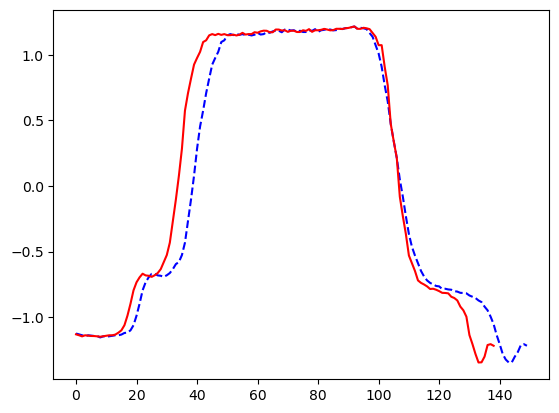

In [ ]:
plt.plot(Q, color="blue", linestyle='--')
plt.plot(Q_scaled, color="red")
# plt.axis('off')
plt.show()

In [ ]:
D, backtrack = ps_distance_p(Q_scaled, X_test[0], 2, 5, 3, "ed") # 16580.84

DP Progress:  59%|█████▊    | 13792/23490 [56:32<39:45,  4.07it/s]s] 


KeyboardInterrupt: 

In [ ]:
backtrack

[((0, 23), (0, 27)), ((23, 115), (27, 118)), ((115, 139), (118, 150))]